# HW2: Spam detection with naive bayes

*by Alexander Marinkiy*

## Task

* Download sms-spam dataset https://archive.ics.uci.edu/ml/datasets/sms+spam+collection
* Choose and argument metric for quality
* Code «by a hands» naive bayes for spam detection task;
* Choose a measure of a test's accuracy and argument your choice;
Perform 5-fold validation for this task;
* Compare your results with sklearn naive_bayes
* I expect your result as self-sufficient (with all comments/graph/etc.)
Jupiter notebook in your GitHub in 2 weeks (next lecture).

## 1. EDA

In [1]:
# importing librarires
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import scipy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score


In [2]:
# read file to dataframe
df = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "text"])
df.head(n=5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print('There are', df.shape[0], 'rows and', df.shape[1], 'columns in our dataset')

There are 5572 rows and 2 columns in our dataset


In [4]:
# let's check the distribution of labels in dataset
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

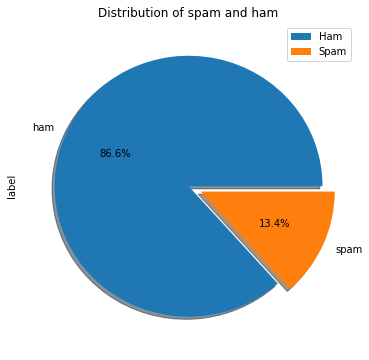

In [5]:
# Visualizing the distribution
df["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.legend(["Ham", "Spam"])
plt.title('Distribution of spam and ham')
plt.show()

Our sample is clearly imbalanced.

In [6]:
df.isnull().values.any()

False

There are no missing values in the dataset

## 2. Choosing metric for quality

Our sample is imbalanced, and this means that accuracy will not be good indicator of the quality of our model. We can just predict the majority class for all elements of test sample and still get 86% accuracy, which sounds like a reasonably good model. Therefore, our main indicators should be Precision, Recall and F1 score. 

If we need to choose just one metric of model quality it is reasonable to choose F1 score since it accounts for both Precision and Recall.

## 3. Data Preprocessing

In [7]:
# replace 'ham' with 0 and 'spam' with 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

Now, lets assume that if we have 10 or more digits in a row - it's a phone number. The assumption will not always hold, but it may be good enough.

In [8]:
# Use regular expressions to find all words with over 10 digits in a row
text_processed = []
for i in df['text']:
    i = re.sub("\d{10,}\w|\d{10,}",
        "digitsphonenumber",
        i)
          
    text_processed.append(i)

df['text'] = text_processed

In [9]:
# Creating training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 5572
Number of rows in the training set: 4179
Number of rows in the test set: 1393


In [10]:
# transforming the data using CountVectorizer. We gonna use n_grams in range 1-2.
count_vector = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_trans = count_vector.fit_transform(X_train)
X_test_trans = count_vector.transform(X_test)

## 4. Naive Bayes implementation from scratch

First of all, lets calculate probabilities of spam and ham in our dataset

$$P(ham) = \frac{number\, of\, documents\, belonging\, to\, category\, ham}{total\, number\, of\, documents}$$

$$P(spam) = \frac{no\ of\ documents\ belonging\ to\ category\ spam}{total\ no\ of\ documents}$$

In [11]:
# P(spam)
p_spam = sum(y_train) / len(y_train)
p_spam

0.1342426417803302

In [12]:
# P(ham)
p_ham = 1 - sum(y_train) / len(y_train)
p_ham

0.8657573582196698

Secondly, for each word we will find probability of this word apperaing in spam and ham message

$$P(word1 | ham) = \frac{count\ of\ word1\ belonging\ to\ category\ ham + 1}{total\ count\ of\ words\ belonging\ to\ ham\ + number\ of\ distinct\ words\ in\ training\ data\ sets} $$

$$P(word1 | spam) = \frac{count\ of\ word1\ belonging\ to\ category\ spam + 1}{total\ count\ of\ words\ belonging\ to\ spam\ + number\ of\ distinct\ words\ in\ training\ data\ sets} $$

In [13]:
# find probabilities for spam
indices = np.where(y_train == 1)[0]
spam = X_train_trans.tocsr()[indices,:]

frequency_spam = spam.toarray().sum(axis=0) + 1
probability_spam = frequency_spam / (sum(frequency_spam))

In [14]:
# find probabilities for ham
indices = np.where(y_train == 0)[0]
ham = X_train_trans.tocsr()[indices,:]

frequency_ham = ham.toarray().sum(axis=0) + 1
probability_ham = frequency_ham / (sum(frequency_ham))



Finally, lets find log of P(ham | bodyText) and P(spam | bodyText)

$$ log(P(ham | bodyText)) = log(P(ham)) + log(P(bodyText | ham)) = log(P(ham)) + log(P(word1 | ham)) + log(P(word2 | ham)) … $$

$$log(P(spam | bodyText)) = log(P(spam)) + log(P(bodyText | spam)) = log(P(spam)) + log(P(word1 | spam)) + log(P(word2 | spam)) …$$

In [15]:
def spam_or_ham(arr):
    prob_ham = np.log(p_ham)
    prob_spam = np.log(p_spam)
    arr = scipy.sparse.find(arr)
    for i in range(len(arr[1])):
        prob_ham = prob_ham + np.log(probability_ham[arr[1][i]]) * arr[2][i]
        prob_spam = prob_spam + np.log(probability_spam[arr[1][i]]) * arr[2][i]

    if prob_ham >= prob_spam:
        return 0
    else:
        return 1

ans = []
for i in X_test_trans:
    ans.append(spam_or_ham(i))

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, ans))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1207
           1       0.97      0.96      0.96       186

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.98      0.98      0.98      1393
weighted avg       0.99      0.99      0.99      1393



## 5. Lets rewrite this model as a class

In order to conduct cross-validation and use model in the future it is reasonable to rewrite our code as class.

In [17]:
class custom_NBclassifier(BaseEstimator):
    def __init__(self):
        # initialize object of class
        self.p_spam = None
        self.p_spam = None
        self.probability_spam = None
        self.probability_ham = None

    def fit(self, X, y):
        # P(spam) & P(ham)
        self.p_spam = sum(y) / len(y)
        self.p_ham = 1 - sum(y) / len(y)

        # find probabilities for spam
        indices = np.where(y == 1)[0]
        spam = X.tocsr()[indices,:]
        frequency_spam = spam.toarray().sum(axis=0) + 1
        self.probability_spam = frequency_spam / (sum(frequency_spam))

        # find probabilities for ham
        indices = np.where(y == 0)[0]
        ham = X.tocsr()[indices,:]
        frequency_ham = ham.toarray().sum(axis=0) + 1
        self.probability_ham = frequency_ham / (sum(frequency_ham))

    def predict(self, X):
        ans = []
        for i in X:
            ans.append(spam_or_ham(i))
        return ans

    def spam_or_ham(self, arr):
        prob_ham = np.log(self.p_ham)
        prob_spam = np.log(self.p_spam)
        arr = scipy.sparse.find(arr)
        for i in range(len(arr[1])):
            prob_ham = prob_ham + np.log(self.probability_ham[arr[1][i]]) * arr[2][i]
            prob_spam = prob_spam + np.log(self.probability_spam[arr[1][i]]) * arr[2][i]

        if prob_ham >= prob_spam:
            return 0
        else:
            return 1

## 6. Comparing with Naive Bayes sklearn implementation

In [18]:
# training model
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_trans, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [19]:
print(classification_report(y_test, naive_bayes.predict(X_test_trans)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1207
           1       0.97      0.96      0.96       186

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.98      0.98      0.98      1393
weighted avg       0.99      0.99      0.99      1393



In [20]:
# cross val scores for sklearn implementation
naive_bayes = MultinomialNB()
print(cross_val_score(naive_bayes, X_train_trans, y_train, cv=5, scoring = 'f1')) 

[0.97849462 0.97488038 0.97129187 0.9760479  0.9760479 ]


In [23]:
# cross val scores for custom implementation
clf = custom_NBclassifier()
print(cross_val_score(clf, X_train_trans, y_train, cv=5, scoring = 'f1')) 

[0.99056604 0.99574468 0.99122807 0.99534884 0.99152542]


## Results

We can see that our implementation of Naive Bayes model achieved **similar model quality** on cross validation as sklearn implementation :)